In [21]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import networkx as nx
import matplotlib.pyplot as plt
from src.models.MatchingType import MatchingType

In [22]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [23]:
def get_abbreviations_with_names():
    cur.execute("select id, name, abbreviation, matching_certainty from unmapped_authors where matching_type = ? or matching_type = ?", (MatchingType.FUZZY_MATCH.name, MatchingType.DIRECT_MATCH.name))
    rows = cur.fetchall()
    authors = pd.DataFrame(columns=["id", "name", "abbreviation", "certainty"], data=rows)
    authors.set_index("id", inplace=True)
    return authors

authors = get_abbreviations_with_names()

In [24]:
# set certainty of a row to the average certainty over all rows with same name and abbreviation, ignore nan values
mean_certainty = authors.groupby(["name", "abbreviation"])["certainty"].transform(lambda x: np.mean(x))
authors["certainty"] = mean_certainty

In [25]:
authors["name_pointing_to_abbreviation_count"] = authors.groupby(["name", "abbreviation"])["name"].transform("count")
authors["abbreviation_pointing_to_name_count"] = authors.groupby(["name", "abbreviation"])["abbreviation"].transform("count")

In [26]:
# drop duplicates based on name, abbreviation, certainty. I can drop them because ..._count saved the count
authors.drop_duplicates(subset=["name", "abbreviation", "certainty"], inplace=True)

In [27]:
# set the share that the name has of all names that point to that abbreviation
authors_with_name_pointing_to_abbreviation_sum =  authors.groupby(["abbreviation"]).agg(names_pointing_to_abbreviation_sum=("name_pointing_to_abbreviation_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_name_pointing_to_abbreviation_sum, on="abbreviation")
authors["name_pointing_to_abbreviation_share"] = authors["name_pointing_to_abbreviation_count"] / authors["names_pointing_to_abbreviation_sum"]

In [28]:
# set the share that the abbreviation has of all abbreviations that point to that name
authors_with_abbreviation_pointing_to_name_sum = authors.groupby(["name"]).agg(abbreviations_pointing_to_name_sum=("abbreviation_pointing_to_name_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_abbreviation_pointing_to_name_sum, on="name")
authors["abbreviation_pointing_to_name_share"] = authors["abbreviation_pointing_to_name_count"] / authors["abbreviations_pointing_to_name_sum"]

In [29]:
# calculate a final score for the weighted edge between name and abbreviation
authors["score"] = authors["certainty"] + authors["name_pointing_to_abbreviation_share"] + authors["abbreviation_pointing_to_name_share"]

In [30]:
# reduce the problem space to a bipartite graph, assigning all (name, abbreviation) pairs that are not connected to the graph as final/solved
# add pairs to final mapping where abbreviation_pointing_to_name_count == 1 or name_pointing_to_abbreviation_count == 1 and remove those from the authors df#
#one_to_one_mappings = authors[(authors["abbreviations_pointing_to_name_sum"] == 1) & (authors["names_pointing_to_abbreviation_sum"] == 1)]
#final_mapping = pd.concat([final_mapping, one_to_one_mappings[["name", "abbreviation"]]], ignore_index=True)

#authors = authors[(authors["abbreviations_pointing_to_name_sum"] != 1) | (authors["names_pointing_to_abbreviation_sum"] != 1)]

In [31]:
# remove self referencing nodes
authors = authors[authors["name"] != authors["abbreviation"]]

In [32]:
# add name and abbreviation as nodes list and remove duplicates
nodes = list(authors["name"].unique()) + list(authors["abbreviation"].unique())

# add unique edges based on entries in the authors table
edges = []
for index, row in authors.iterrows():
    edges.append((row["name"], row["abbreviation"]))

processing graph with 1 names
processing graph with 2 names
processing graph with 3 names
processing graph with 4 names
processing graph with 5 names
processing graph with 6 names
processing graph with 7 names
processing graph with 8 names
processing graph with 9 names
processing graph with 10 names
processing graph with 11 names
processing graph with 12 names
processing graph with 13 names
processing graph with 14 names
processing graph with 15 names
processing graph with 16 names
processing graph with 17 names
processing graph with 18 names
processing graph with 19 names
processing graph with 20 names
processing graph with 21 names
processing graph with 22 names
processing graph with 23 names
processing graph with 24 names
processing graph with 25 names
processing graph with 26 names
processing graph with 27 names
processing graph with 28 names
processing graph with 29 names


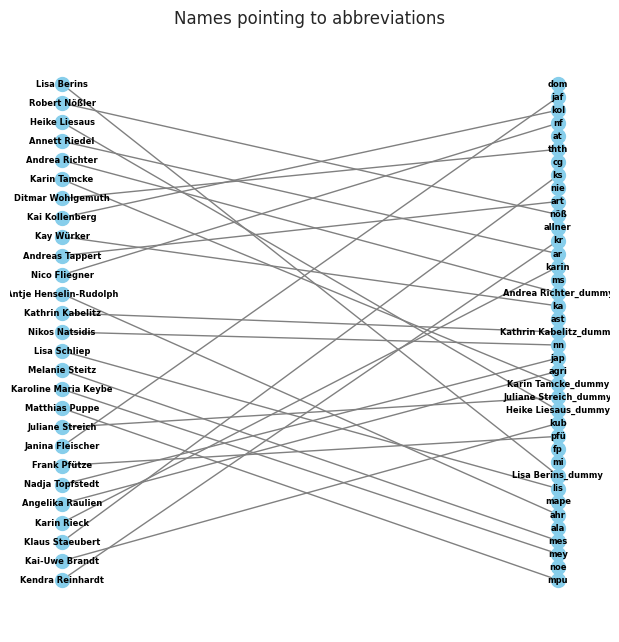

In [34]:
plt.figure(figsize=[6, 6])
plt.cla()
save_image = True

for i in range(1, min(authors.shape[0], 30)):
    print(f"processing graph with {i} names")
    G = nx.Graph()
    G.clear()
    author_list = list(authors["name"].unique())[:i]
    abbr_list = list(authors[authors["name"].isin(author_list)]["abbreviation"].unique())
    G.add_nodes_from(author_list, bipartite=0)
    G.add_nodes_from(abbr_list, bipartite=1)
    dummy_nodes = [f"{name}_dummy" for name in author_list]
    G.add_nodes_from(dummy_nodes, bipartite=1)

    edges = []
    for index, row in authors[authors["name"].isin(author_list) & authors["abbreviation"].isin(abbr_list)].iterrows():
        G.add_edges_from([(row["name"], row["abbreviation"])], weight=round(row["score"],2) * -1)

    for name in author_list:
        G.add_edges_from([(name, f"{name}_dummy")], weight=0)

    try:
        new_edges = nx.bipartite.minimum_weight_full_matching(G, top_nodes=list(authors["name"].unique())[:i], weight="weight")

        if save_image:
            if i % 3 != 0:
                continue
            plt.cla()
            plt.clf()
            # plot the original graph and the solution
            pos = nx.bipartite_layout(G, author_list)
            nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_weight='bold', edge_color='gray')
            # Add edge labels
            edge_labels = nx.get_edge_attributes(G, 'weight')  # Assuming the edge weights are stored as 'weight' attribute
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.8)
            plt.title('Names pointing to abbreviations')
            plt.savefig(f'../reports/figures/names_to_abbreviations_matching_original_{i}.png', dpi=300)
    
            plt.cla()
            plt.clf()
            g_new = nx.Graph()
            g_new.clear()
            g_new.add_nodes_from(author_list, bipartite=0)
            g_new.add_nodes_from(abbr_list, bipartite=1)
            g_new.add_edges_from(new_edges.items())
            pos = nx.bipartite_layout(g_new, author_list)
            nx.draw(g_new, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_weight='bold', edge_color='gray')
            plt.title('Names pointing to abbreviations')
            plt.savefig(f'../reports/figures/names_to_abbreviations_matching_matched_{i}.png', dpi=300)
    except ValueError:
        print(f"ValueError at index {i}")
        plt.cla()
        plt.clf()
        pos = nx.bipartite_layout(G, author_list)
        nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_weight='bold', edge_color='gray')
        # Add edge labels
        edge_labels = nx.get_edge_attributes(G, 'weight')  # Assuming the edge weights are stored as 'weight' attribute
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.8)
        plt.title('Names pointing to abbreviations')
        plt.savefig(f'../reports/figures/names_to_abbreviations_matching_fail_{i}.png', dpi=300)
        break



In [19]:
print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

number of nodes: 102, number of edges: 93


In [20]:
new_edges = nx.bipartite.minimum_weight_full_matching(G, top_nodes=list(authors["name"].unique()), weight="score")

ValueError: cost matrix is infeasible

In [33]:
# remove old edges
G.remove_edges_from(edges)
# set new edges
G.add_edges_from(new_edges.items())

In [34]:
print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

number of nodes: 955, number of edges: 855


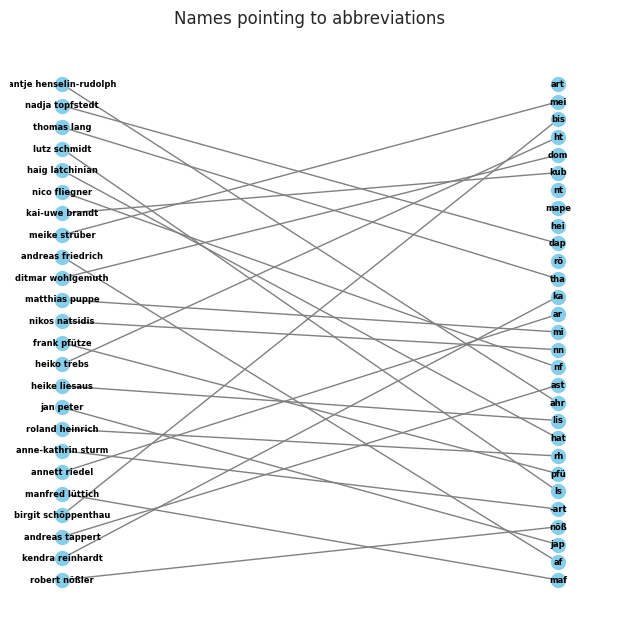

In [17]:
# Draw the graph
pos = nx.bipartite_layout(G, list(authors["name"].unique()))
plt.figure(figsize=[6, 6])
nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_weight='bold', edge_color='gray')
plt.title('Names pointing to abbreviations')
plt.savefig('../reports/figures/names_to_abbreviations_matching_test.png', dpi=300)